In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import pandas as pd
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import neighbors, datasets
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from scipy.spatial import ConvexHull
from tqdm import tqdm
import random
plt.style.use('ggplot')
import pickle
from sklearn import tree
from sklearn.tree import export_graphviz
from joblib import dump, load
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
%matplotlib inline
from sklearn.impute import SimpleImputer
from scipy import interpolate
from scipy.interpolate import interp1d


In [2]:
MAX_DEPTH=6
NUMESTIMATORS=2

In [3]:
Ef=pd.read_excel('./2022summer/adeptphase3/BIOTYPES_HC_withBiofactors_21_1008.xlsx')
Ef.columns

Ef_=Ef[['Subid',#'Age', 'Sex',
       'EEG1', 'EEG2', 'EEG3', 'EEG4', 'EEG5', 'EEG6', 'LATENCY',
       'ANTISACCADE', 'BACS', 'SST', 'IEA']]


In [4]:
xf=pd.read_csv('./2022summer/adeptphase2/Cognition.csv',index_col=0)
xf.index.name='subject_id'
df=pd.read_csv('combined_bsnip.csv',index_col=0).drop('DSM',axis=1)
df=df.join(xf)#.head()
df=df.join(Ef_.set_index('Subid'))

In [5]:
DELVAR=['project']#,'Age','Sex','BSNIP1VS2','Psychosis','BACS_COMP_Z','LATENCY','SST','BACS','ANTISACCADE']
cols=[x for x in df.columns if x not in DELVAR]
df=df[cols]

In [6]:
#df=pd.read_csv('combined_bsnip.csv',index_col=0).drop('DSM',axis=1)
#df=df.drop('project',axis=1)
#df=df.drop('BACS_COMP_Z_within',axis=1)
#df.head()

In [7]:
feature_names=df.columns
feature_names=feature_names[1:]
feature_names[62]

'Psychosis'

In [8]:
#df=df[df['Biotype']==3]
df=df.dropna()
df0=df
[p1,p2,p3]=(df0.Biotype.value_counts()/df0.Biotype.value_counts().sum()).values

In [9]:
df.Biotype.value_counts()
# 3 is HC

3    334
1    293
2    254
Name: Biotype, dtype: int64

In [10]:
def getRES(df0,MAX_DEPTH=6,NUMESTIMATORS=2,MODELfile='model23.mod'):
    df=df0
    X=df.iloc[:,1:].values
    y=df.Biotype.values#.astype(str)
    y=[(int(x)==2)+0 for x in y ]

    MODEL={}
    
    ACC=[]
    CLFh={}
    for run in np.arange(500):
        auc,CLFS=getAuc(X,y,test_size=0.2,max_depth=MAX_DEPTH,n_estimators=NUMESTIMATORS,
                   minsplit=2,VERBOSE=False, USE_ONLY=[2])
        ACC=np.append(ACC,auc)
        if auc > 0.5:
            CLFh[auc]=CLFS
    CLFstarA=CLFh[np.array([k for k in CLFh.keys()]).max()][0]
    f1,ROCA=getFmap(CLFstarA,X,y)
    
    MODEL[2]={'estimator':CLFstarA,'fmap':f1,'rocs':ROCA}

    #df=df0[df0.Biotype.isin([1,5])]
    df=df0
    X=df.iloc[:,1:].values
    y=df.Biotype.values#.astype(str)
    y=[(int(x)==3)+0 for x in y ]

    ACC=[]
    CLFh={}
    for run in np.arange(500):
        auc,CLFS=getAuc(X,y,test_size=0.2,max_depth=MAX_DEPTH,n_estimators=NUMESTIMATORS,
                   minsplit=2,VERBOSE=False, USE_ONLY=[2])
        ACC=np.append(ACC,auc)
        if auc > 0.5:
            CLFh[auc]=CLFS
    CLFstarB=CLFh[np.array([k for k in CLFh.keys()]).max()][0]
    f2,ROCB=getFmap(CLFstarB,X,y)
    MODEL[3]={'estimator':CLFstarB,'fmap':f2,'rocs':ROCB}

    R=[]
    for i in np.arange(.7,.99,.01):
        for j in np.arange(.7,.99,.01):
            R=np.append(R,[i,j,getacc(i,j,p1,p2,p3,f1,f2)])
    R=pd.DataFrame(R.reshape(len(R)//3,3))
    R.columns=['c1','c2','acc']
    R['s1']=f1(1-R.c1)
    R['s2']=f2(1-R.c2)


    X_test=df.values.astype(np.float32)
    L=[]

    for sample_id in np.arange(len(X_test)):
        Node_index=[]
        for i in CLFstarA.estimators_:
            threshold= i.tree_.threshold
            feature= i.tree_.feature
            node_indicator = i.tree_.decision_path(X_test)
            leaf_id = i.tree_.apply(X_test)

            node_index = node_indicator.indices[
            node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]]
            Node_index=np.append(Node_index,node_index)

        for i in CLFstarB.estimators_:
            threshold= i.tree_.threshold
            feature= i.tree_.feature
            node_indicator = i.tree_.decision_path(X_test)
            leaf_id = i.tree_.apply(X_test)

            node_index = node_indicator.indices[
            node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]]
            Node_index=np.append(Node_index,node_index)
        L=np.append(L,len(set(Node_index))-2)
    L=np.array(L)
    #print(np.mean(L),np.median(L))
    #sns.displot(L);


    RES=R.sort_values('acc',ascending=False).head(1)
    RES['nq_mean']=np.mean(L)
    RES['nq_median']=np.median(L)
    
    if MODELfile is not None:
        import dill
        with open(MODELfile, "wb") as dill_file:
            dill.dump(MODEL, dill_file)
    #dill_file.close()
    
    return RES, ROCA, ROCB, CLFstarA, CLFstarB

In [11]:
Rs,ROCa,ROCb,CLFstarA,CLFstarB=getRES(df0,MAX_DEPTH=10)
Rs

NameError: name 'getAuc' is not defined

In [41]:
! ls -lhtr | grep model*mod


ls: write error: Broken pipe


In [18]:
# load model
import dill
with open('model123eeg.mod_0','rb') as f:
    M=dill.load(f)

    

In [19]:
M.keys()

dict_keys([1, 2, 3])

In [20]:
import shap
clfA=M[2]['estimator']
clfB=M[3]['estimator']
clfC=M[1]['estimator']


In [21]:
th1=M[2]['rocs'][list(M[2]['rocs'].keys())[0]]['thresholds'][1]#['thresholds']
th2=M[3]['rocs'][list(M[3]['rocs'].keys())[0]]['thresholds'][1]#['thresholds']
print(th1,th2)

0.4856018142311272 0.5300416842993977


In [22]:
def prob_(x):
    a=clfA.predict_proba(x.reshape(1, -1))
    b=clfB.predict_proba(x.reshape(1, -1))
    #print(a)
    if a[0][0] > th1:
        d=2
    else:
        if b[0][0] > th2:
            d=3
        else:
            d=1
    return d

In [23]:
def prob__(X):
    return 1+(clfA.predict_proba(X)[:,0]>th1)*1+(clfB.predict_proba(X)[:,0]>th2)*2


In [24]:
df=df0
X=df.iloc[:,1:].values
y=df.Biotype.values#.astype(str)
y=[(int(x)==2)+0 for x in y ]

In [25]:
explainerX = shap.Explainer(prob__,X)
shap_valuesX=explainerX(df.iloc[:,1:])

Permutation explainer: 882it [00:48, 15.71it/s]                                 


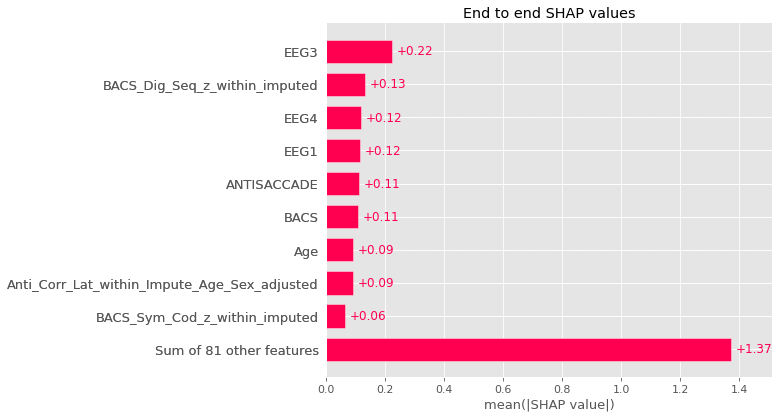

In [26]:
shap.plots.bar(shap_valuesX, show=False)
plt.title('End to end SHAP values')
plt.savefig('shapXeeg.png',dpi=300,bbox_inches='tight',transparent=True)

In [27]:
explainer = shap.Explainer(clfA.predict,X)
shap_values=explainer(df.iloc[:,1:])

Permutation explainer: 882it [00:22, 21.23it/s]                                 


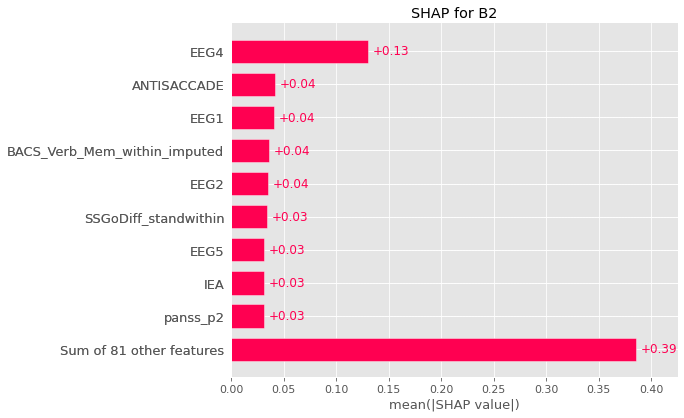

In [28]:
shap.plots.bar(shap_values,show=False)
plt.title('SHAP for B2')
plt.savefig('shap2eeg.png',dpi=300,bbox_inches='tight',transparent=True)

In [29]:
df=df0
X=df.iloc[:,1:].values
y=df.Biotype.values#.astype(str)
y=[(int(x)==3)+0 for x in y ]

In [30]:
explainerb = shap.Explainer(clfB.predict,X)
shap_valuesb=explainerb(df.iloc[:,1:])

Permutation explainer: 882it [00:21, 22.00it/s]                                 


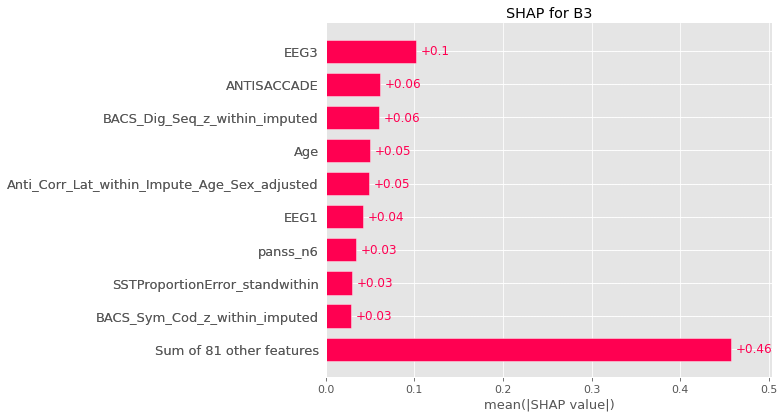

In [31]:
shap.plots.bar(shap_valuesb,show=False)
plt.title('SHAP for B3')

plt.savefig('shap3eeg.png',dpi=300,bbox_inches='tight',transparent=True)

In [32]:
df=df0
X=df.iloc[:,1:].values
y=df.Biotype.values#.astype(str)
y=[(int(x)==1)+0 for x in y ]

Permutation explainer: 882it [00:21, 21.86it/s]                                 


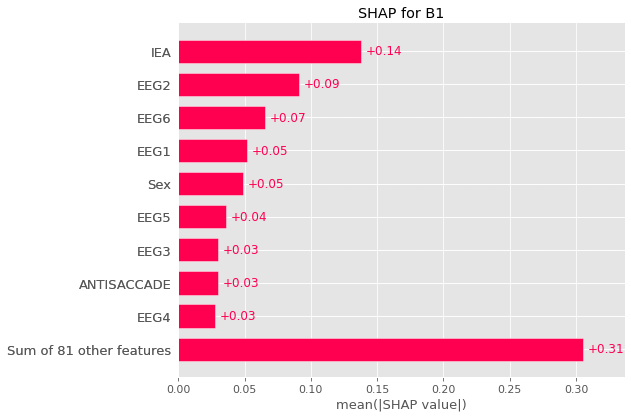

In [33]:
explainerC = shap.Explainer(clfC.predict,X)
shap_valuesC=explainerC(df.iloc[:,1:])
shap.plots.bar(shap_valuesC,show=False)
plt.title('SHAP for B1')

plt.savefig('shap1eeg.png',dpi=300,bbox_inches='tight',transparent=True)